# Multivariate QuasiCopula GWAS with Mixed Marginals

Here we assume each sample have $d$ observations, and we estimate a general covariance matrix 

$$\mathbf{\Gamma} = \mathbf{L}\mathbf{L}^t$$

In [1]:
using Revise
using QuasiCopula
using ToeplitzMatrices
using Distributions
using GLM
using StatsBase

k = 10 # number of causal SNPs]
d = 4 # number of phenotypes
Γ = Matrix(SymmetricToeplitz(0.75.^(0:(d-1))))
σ2true = 0.1

qc_model, G, Btrue, Γtrue, γtrue, τtrue = simulate_multivariate_traits(
    n = 1000, # sample size
    p = 3, # number of fixed effects, including intercept
    d = d, # number of phenotypes
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    Γ = Γ,
    seed = 2024,
    σ2true = σ2true,
    possible_distributions = [Bernoulli, Poisson, Normal],
    use_VC_model=false
);

qc_model.data.Y

1000×4 Matrix{Float64}:
 0.0  -1.43262    0.0  -0.511856
 0.0  -0.373219   1.0   0.354183
 1.0  -0.260896   2.0   0.26059
 1.0  -1.02524    0.0  -0.606041
 1.0  -0.435392   0.0  -0.284081
 1.0   0.0702987  0.0   0.306805
 0.0   0.167149   1.0   0.623861
 0.0  -0.828675   0.0  -0.190445
 1.0  -0.930606   2.0   0.513846
 0.0  -0.251939   1.0  -0.663489
 0.0  -0.804611   0.0  -0.232759
 0.0  -1.29853    1.0  -0.0871844
 0.0  -0.272051   1.0  -0.454009
 ⋮                     
 1.0   0.131034   3.0  -0.653204
 0.0  -0.587926   1.0   0.263022
 1.0  -0.916511   1.0   0.0960331
 0.0   0.0693688  1.0  -0.147744
 1.0  -0.319483   2.0   0.475311
 0.0  -1.2467     2.0   0.612494
 0.0  -0.334317   0.0  -0.479247
 0.0  -0.0414028  2.0   0.455918
 1.0   0.124398   1.0   0.37156
 0.0  -0.733231   1.0   0.419965
 1.0   0.624586   2.0   0.114638
 0.0  -0.98324    1.0   0.235499

In [2]:
@time optm = QuasiCopula.fit!(qc_model);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       24
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

In [3]:
[vec(qc_model.B) vec(Btrue)]

12×2 Matrix{Float64}:
  0.339321     0.243157
  0.238562    -0.0210807
  0.00446937  -0.112301
 -0.388686    -0.400046
  0.33735      0.312879
  0.233604     0.211803
 -0.0680236   -0.0254639
 -0.4612      -0.433712
 -0.465076    -0.482505
  0.0363257    0.0413149
 -0.176512    -0.191238
  0.355917     0.353612

In [4]:
# compare Γ
L = qc_model.L
cov2cor(L.L*L.L')

4×4 Matrix{Float64}:
 1.0       0.844064  0.325959  0.56826
 0.844064  1.0       0.747124  0.916223
 0.325959  0.747124  1.0       0.860628
 0.56826   0.916223  0.860628  1.0

In [5]:
cov2cor(Γtrue)

4×4 Matrix{Float64}:
 1.0       0.75    0.5625  0.421875
 0.75      1.0     0.75    0.5625
 0.5625    0.75    1.0     0.75
 0.421875  0.5625  0.75    1.0

In [6]:
# compare nuisance parameters 
[qc_model.ϕ [σ2true for _ in 1:length(qc_model.ϕ)]]

2×2 Matrix{Float64}:
 0.239769  0.1
 0.113007  0.1

## GWAS via likelihood ratio test on top SNPs

In [7]:
# gwas
result = QuasiCopula.multivariateGWAS_adhoc_lrt(qc_model, G)
# result = QuasiCopula.multivariateGWAS_adhoc_lrt(qc_model, G, pval_cutoff=1.0)
pvals = result.pvals

# compute power
discovered_snps = findall(x -> x < 0.05/length(pvals), pvals)
causal_snps = unique!([x[1] for x in findall(!iszero, γtrue)])
power = length(discovered_snps ∩ causal_snps) / length(causal_snps)
FP = length(setdiff(discovered_snps, causal_snps))
println("power = $power, FP = $FP")

Estimating grad under null 100%|█████████████████████████| Time: 0:00:44
Running LRT until -log10(p) < 3.301 Time: 0:01:00 (10 iterations))


power = 0.9, FP = 0


In [12]:
result.Rs[causal_snps]

10-element Vector{Float64}:
 183.64009300903075
 143.22140165074958
 184.00536503686672
 151.19518362764148
 156.79136981538497
 137.7693907590132
 150.62502988359125
 149.0845849814702
  77.38252045217976
 137.7514315770344

In [16]:
result.Rs[setdiff(1:length(result.Rs), causal_snps)] |> sort

990-element Vector{Float64}:
  3.258426960292505
  4.657665510693972
  4.790229138283985
  5.341166108514894
  6.092688484706491
  6.2401414293600155
  6.4811382366832175
  6.901462760361416
  7.172580440382585
  7.357226663390165
  7.521084808408719
  7.806754916816624
  8.88237174083201
  ⋮
 79.87309417413705
 80.7951106595761
 81.25332223417169
 83.34069864426283
 83.89689466425546
 84.27521337960454
 85.13260835060328
 87.37359996849219
 89.8231553473775
 91.10857990196243
 93.09536904920672
 97.4969110773405

Check QQ plot

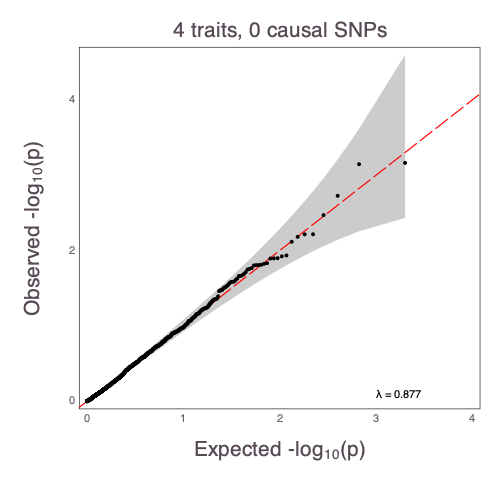

In [102]:
using MendelPlots

# 2 normal, 1 bernoulli, 1 poisson
qq(pvals, dpi=100, titles="4 traits, $k causal SNPs")
display("image/png", read("qqplot.png"))

## Fit QuasiCopula model to Gaussian traits

$$y_i \sim N(\mu_i, \Sigma)$$

In [26]:
n = qc_model.data.n
d = qc_model.data.d
X = qc_model.data.X
Gfloat = convert(Matrix{Float64}, G, center=true, scale=true)
Σ = Matrix(SymmetricToeplitz(0.5.^(0:(d-1))))

# sample Gaussian phenotypes
Y = zeros(n, d)
for i in 1:n
    Xi = X[i, :]
    Gi = Gfloat[i, :]
    μi = Btrue' * Xi + γtrue' * Gi
    Y[i, :] .= rand(MvNormal(μi, Σ))
end
Y

# fit QC model
qc_model2 = QuasiCopula.MultivariateCopulaModel(Y, X, [Normal for i in 1:d], [IdentityLink() for i in 1:d])
@time optm = QuasiCopula.fit!(qc_model2);

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       26
                     variables with only lower bounds:        4
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -6.6501825e+03 0.00e+00 1.00e+02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [27]:
# gwas
result2 = QuasiCopula.multivariateGWAS_adhoc_lrt(qc_model2, G)
pvals = result2.pvals

# compute power
discovered_snps = findall(x -> x < 0.05/length(pvals), pvals)
causal_snps = unique!([x[1] for x in findall(!iszero, γtrue)])
power = length(discovered_snps ∩ causal_snps) / length(causal_snps)
FP = length(setdiff(discovered_snps, causal_snps))
println("(simulate under Gaussian model) power = $power, FP = $FP")

Estimating grad under null 100%|█████████████████████████| Time: 0:00:01
Running LRT until -log10(p) < 3.301 Time: 0:00:01 (11 iterations))


(simulate under Gaussian model) power = 0.8, FP = 2
